**Imports**

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import cv2
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Optimizers**

In [7]:
def adam_opt(model,l_rate):
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=l_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def rms_prop(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=l_rate,
      rho=0.9,
      epsilon=1e-07)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model
  
def momentum_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.9,
      nesterov=False) #################
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def vanilla_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.0)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model


**Data Preprocessing**

In [8]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Select 500 images per class from the training set
num_classes = 10
num_samples_per_class = 500
x_train_tiny = np.zeros((num_classes*num_samples_per_class, 32, 32, 3))
y_train_tiny = np.zeros((num_classes*num_samples_per_class, 1))
for class_idx in range(num_classes):
    class_indices = np.where(y_train == class_idx)[0]
    random_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    x_train_tiny[class_idx*num_samples_per_class:(class_idx+1)*num_samples_per_class,:,:,:] = x_train[random_indices,:,:,:]
    y_train_tiny[class_idx*num_samples_per_class:(class_idx+1)*num_samples_per_class,:] = y_train[random_indices,:]

# Use the same 10,000 images for testing as per the CIFAR-10 dataset
X_test = x_test
Y_test = y_test

X_train = x_train_tiny
Y_train = y_train_tiny
# print(np.where(y_train == 0))

#Normalizing data
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std  ####################

n_rows = X_train.shape[0]
perm = np.random.permutation(n_rows)
X_train = X_train[perm]
Y_train = Y_train[perm]



X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.16666, random_state=42)




print("X_train shape: ",X_train.shape)
print("Y_train shape: ",Y_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_test shape: ",Y_test.shape)

X_train shape:  (4166, 32, 32, 3)
Y_train shape:  (4166, 1)
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000, 1)


**Implementing ResNet-18 architecture**

When we increase the number of layers, there is a common problem in deep learning associated with that called the Vanishing/Exploding gradient. This causes the gradient to become 0 or too large. Thus when we increases number of layers, the training and test error rate also increases. 

In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Blocks. In this network, we use a technique called skip connections. The skip connection connects activations of a  layer to further layers by skipping some layers in between. This forms a residual block. Resnets are made by stacking these residual blocks together.

The advantage of adding this type of skip connection is that if any layer hurt the performance of architecture then it will be skipped by regularization. So, this results in training a very deep neural network without the problems caused by vanishing/exploding gradient.

Apart from the vanishing gradients, there is another reason that we commonly use them. For a plethora of tasks there is some information that was captured in the initial layers and we would like to allow the later layers to also learn from them.

In ResNet-18, downsample is used in the residual blocks where the stride is greater than 1. When the stride is greater than 1, the convolutional layer reduces the spatial dimensions of the input feature map. However, the shortcut connection (i.e., the skip connection) requires the output of the convolutional layer to have the same dimensions as the input feature map. To achieve this, downsample is used to perform spatial downsampling on the input feature map before adding it to the output of the convolutional layer.

**For Implementing this architecture we use functional API instead of sequential API** because of its flexiblity.

ResNet18 is a neural network architecture that consists of 18 layers, which are:

1. Convolutional layer with 64 filters and kernel size of 7x7
Batch normalization layer
2. Rectified Linear Unit (ReLU) activation function
3. Max pooling layer with pool size of 3x3 and stride of 2
4. 2 ResNet blocks, each containing 2 convolutional layers with 64 filters, kernel size of 3x3 and stride of 1, followed by batch normalization and ReLU activation function
5. 2 ResNet blocks, each containing 2 convolutional layers with 128 filters, kernel size of 3x3 and stride of 2 (except for the first layer in each block which has a stride of 2), followed by batch normalization and ReLU activation function
6. 2 ResNet blocks, each containing 2 convolutional layers with 256 filters, kernel size of 3x3 and stride of 2 (except for the first layer in each block which has a stride of 2), followed by batch normalization and ReLU activation function
7. 2 ResNet blocks, each containing 2 convolutional layers with 512 filters, kernel size of 3x3 and stride of 2 (except for the first layer in each block which has a stride of 2), followed by batch normalization and ReLU activation function
8. Global average pooling layer
9. Fully connected layer with 10 units and softmax activation function


Note that some of the layers in ResNet18 are repeated, which is why there are a total of 18 layers in the architecture.

In [14]:
def residual_block(x, filters, stride, downsample=None): #H(x) = F(x)+x
    residual = x 


    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if downsample is not None:
        residual = downsample(residual)

    x = tf.keras.layers.Add()([x, residual]) #does element-wise addition
    x = tf.keras.layers.Activation('relu')(x)

    return x

def ResNet18(num_classes,input_shape = (32,32,3)):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

        # randomly flip the image horizontally
    x = tf.image.random_flip_left_right(input_tensor)

    # randomly rotate the image by up to 15 degrees
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # randomly adjust the brightness of the image
    x = tf.image.random_brightness(x, max_delta=0.2)

    # randomly adjust the contrast of the image
    x = tf.image.random_contrast(x, lower=0.2, upper=1.8)

    x = RandomZoom(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(x) #layer-1
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters = 64 #layer 2-5
    x = residual_block(x, filters,stride=1)
    x = residual_block(x, filters,stride=1)

    filters *= 2 #layer 6-9
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2,downsample=downsample)
    x = residual_block(x, filters,stride=1)

    filters *= 2 #layer 10-13
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    filters *= 2 #layer 14-17
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(num_classes, activation='softmax')(x) #layer-18

    model = tf.keras.models.Model(input_tensor, output_tensor)

    return model


def ResNet18_d(num_classes,x1,x2,x3,x4,dr,input_shape = (32,32,3)):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

        # randomly flip the image horizontally
    x = tf.image.random_flip_left_right(input_tensor)

    # randomly rotate the image by up to 15 degrees
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # randomly adjust the brightness of the image
    x = tf.image.random_brightness(x, max_delta=0.2)

    # randomly adjust the contrast of the image
    x = tf.image.random_contrast(x, lower=0.2, upper=1.8)

    x = RandomZoom(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(x) #layer-1
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters = 64 #layer 2-5
    x = residual_block(x, filters,stride=1)
    x = residual_block(x, filters,stride=1)

    if(x1==1):
      x=tf.keras.layers.Dropout(dr)(x)

    filters *= 2 #layer 6-9
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2,downsample=downsample)
    x = residual_block(x, filters,stride=1)

    if(x2==1):
      x=tf.keras.layers.Dropout(dr)(x)

    filters *= 2 #layer 10-13
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    if(x3==1):
      x=tf.keras.layers.Dropout(dr)(x)

    filters *= 2 #layer 14-17
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    if(x4==1):
      x=tf.keras.layers.Dropout(dr)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(num_classes, activation='softmax')(x) #layer-18

    model = tf.keras.models.Model(input_tensor, output_tensor)

    return model



    

Epoch 1/100


131/131 [==============================] - 26s 92ms/step - loss: 2.7148 - accuracy: 0.1654 - val_loss: 2.2846 - val_accuracy: 0.1355
Epoch 2/100
131/131 [==============================] - 11s 87ms/step - loss: 2.1726 - accuracy: 0.2664 - val_loss: 2.2040 - val_accuracy: 0.1823
Epoch 3/100
131/131 [==============================] - 13s 97ms/step - loss: 1.9958 - accuracy: 0.3036 - val_loss: 1.9710 - val_accuracy: 0.2794
Epoch 4/100
131/131 [==============================] - 11s 86ms/step - loss: 1.8516 - accuracy: 0.3584 - val_loss: 1.9190 - val_accuracy: 0.3165
Epoch 5/100
131/131 [==============================] - 11s 82ms/step - loss: 1.7706 - accuracy: 0.3855 - val_loss: 1.9096 - val_accuracy: 0.3213
Epoch 6/100
131/131 [==============================] - 11s 84ms/step - loss: 1.7000 - accuracy: 0.4023 - val_loss: 1.8958 - val_accuracy: 0.3321
Epoch 7/100
131/131 [==============================] - 11s 88ms/step - loss: 1.6316 - accuracy: 0.4213 - val_loss: 1.8815 - val_accuracy: 0.34

Epoch 1/100


131/131 [==============================] - 24s 90ms/step - loss: 2.9107 - accuracy: 0.1447 - val_loss: 2.3161 - val_accuracy: 0.1019
Epoch 2/100
131/131 [==============================] - 11s 81ms/step - loss: 2.3847 - accuracy: 0.2225 - val_loss: 2.2413 - val_accuracy: 0.1475
Epoch 3/100
131/131 [==============================] - 11s 83ms/step - loss: 2.2036 - accuracy: 0.2549 - val_loss: 2.0485 - val_accuracy: 0.2530
Epoch 4/100
131/131 [==============================] - 11s 87ms/step - loss: 2.0790 - accuracy: 0.2847 - val_loss: 2.0133 - val_accuracy: 0.2938
Epoch 5/100
131/131 [==============================] - 11s 85ms/step - loss: 2.0438 - accuracy: 0.3048 - val_loss: 1.9553 - val_accuracy: 0.3249
Epoch 6/100
131/131 [==============================] - 11s 85ms/step - loss: 1.9457 - accuracy: 0.3217 - val_loss: 1.9053 - val_accuracy: 0.3609
Epoch 7/100
131/131 [==============================] - 11s 86ms/step - loss: 1.9108 - accuracy: 0.3279 - val_loss: 1.9579 - val_accuracy: 0.32

Epoch 1/100


131/131 [==============================] - 24s 91ms/step - loss: 2.8051 - accuracy: 0.1445 - val_loss: 2.2844 - val_accuracy: 0.1307
Epoch 2/100
131/131 [==============================] - 11s 86ms/step - loss: 2.4753 - accuracy: 0.1923 - val_loss: 2.2072 - val_accuracy: 0.1811
Epoch 3/100
131/131 [==============================] - 11s 86ms/step - loss: 2.3282 - accuracy: 0.2266 - val_loss: 2.0789 - val_accuracy: 0.2314
Epoch 4/100
131/131 [==============================] - 11s 84ms/step - loss: 2.2140 - accuracy: 0.2470 - val_loss: 2.0604 - val_accuracy: 0.2518
Epoch 5/100
131/131 [==============================] - 11s 83ms/step - loss: 2.1532 - accuracy: 0.2600 - val_loss: 2.0029 - val_accuracy: 0.2710
Epoch 6/100
131/131 [==============================] - 11s 82ms/step - loss: 2.0825 - accuracy: 0.2804 - val_loss: 1.9569 - val_accuracy: 0.3118
Epoch 7/100
131/131 [==============================] - 11s 84ms/step - loss: 2.0270 - accuracy: 0.2957 - val_loss: 1.9583 - val_accuracy: 0.29

Epoch 1/100


131/131 [==============================] - 26s 92ms/step - loss: 3.0024 - accuracy: 0.1258 - val_loss: 2.3094 - val_accuracy: 0.1283
Epoch 2/100
131/131 [==============================] - 11s 84ms/step - loss: 2.5975 - accuracy: 0.1623 - val_loss: 2.3178 - val_accuracy: 0.1427
Epoch 3/100
131/131 [==============================] - 11s 87ms/step - loss: 2.4151 - accuracy: 0.1935 - val_loss: 2.2953 - val_accuracy: 0.1775
Epoch 4/100
131/131 [==============================] - 11s 86ms/step - loss: 2.3565 - accuracy: 0.2002 - val_loss: 2.2354 - val_accuracy: 0.2086
Epoch 5/100
131/131 [==============================] - 11s 84ms/step - loss: 2.2765 - accuracy: 0.2206 - val_loss: 2.2179 - val_accuracy: 0.2194
Epoch 6/100
131/131 [==============================] - 11s 85ms/step - loss: 2.2109 - accuracy: 0.2285 - val_loss: 2.1886 - val_accuracy: 0.2362
Epoch 7/100
131/131 [==============================] - 11s 85ms/step - loss: 2.1997 - accuracy: 0.2420 - val_loss: 2.1629 - val_accuracy: 0.24

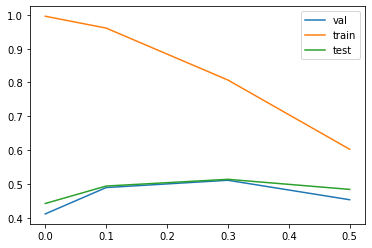

In [16]:
t1 = []
t2 = []
t3 = []

dropout_rates = [0,0.1,0.3,0.5]

    # Add dropout after the second and third block
for dropout_rate in dropout_rates:
    model = ResNet18_d(num_classes,1,0,0,0,dropout_rate)
    
    model = adam_opt(model,0.00001)

    
    model.fit(X_train, Y_train, batch_size=32,validation_data=(X_val, Y_val),epochs=100,verbose=1)

    # Evaluate the model on the test set
    _,val_acc = model.evaluate(X_val, Y_val, verbose=0)
    _,train_acc = model.evaluate(X_train, Y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    t1.append(val_acc)
    t2.append(train_acc)
    t3.append(test_acc)

plt.plot(dropout_rates,t1)
plt.plot(dropout_rates,t2)
plt.plot(dropout_rates,t3)

plt.legend(["val","train","test"])
plt.show()